# Homework 5 - Question 2

Here we will compute the sentiment coming from the email per country. 

In [1]:
## Importation of useful libraries
import pycountry
import pandas as pd
import numpy as np
import os
import seaborn as sns
import datetime
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
import operator
%matplotlib inline

C:\ProgrammationProjects\Installation\Anaconda\envs\ADA\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


<h3>Data loading and cleaning</h3>

We will first load the data, and then clean them. We decided to use the "ExtractedBodyText" for this part, therefore we will drop all the empty cells.

In [2]:
filename = os.path.join('hillary-clinton-emails','Emails.csv')
df_email = pd.read_csv(filename)
df_email = df_email.dropna(axis=0, how='any', subset=['ExtractedBodyText'])
df_email.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...


 To clean the data, we use exactly the same technique as in exercice 1. Therefore, we decided to export this technique to an external function, and just use the function. All the explanations can be found in exercice 1 of the homework. This function will return a map between the indices of the email dataframe and a list of token (coming from the email of the indice)

In [3]:
## Cleaning data with the external script.
## map : (mail index -> list of tokens)
from cleaningData import getTokenMapFromData
map_mail_index_to_token_list = getTokenMapFromData(False)

Starting to import data
Starting cleaning...
Creating tokens...
list token len= 6742
list index len= 6742
Finished!


In [4]:
print('-- Dataframe: ')
print(df_email.ExtractedBodyText[1])
print('-- Token list : ')
print(map_mail_index_to_token_list[1])

-- Dataframe: 
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary
-- Token list : 
['B6', 'H', 'Latest', 'How', 'Syria', 'aiding', 'Qaddafi', '', 'Sid', 'hrc', 'memo', 'syria', 'aiding', 'libya', '030311.docx', 'hrc', 'memo', 'syria', 'aiding', 'libya', '030311.docx', 'March', '3', '2011', 'For', 'Hillary']


<h3>Countries array setup</h3>

In this part, we will create an array of countries name. For each country, we will register the different names it is known of. We will use the library pycountry to achieve that.<br>
While runnning tests, we noticed a lot of problems with abbreviations. A lot of the time the abbreviation was not used in the mail to describe a country, but it could be an abbreviation for an event, the middle name of someone, of simply a spelling mistakes. As our list of bad abbreviation that we didn't take into account grew, we finally decided to remove all of them. Even if we will loose some data, we think our result will be more precise this way rather than using abbreviations.
This was our list of "bad" abbreviations before we decided to not use any of them:<br>
<i>bad_countries_abbrev = ["re", "fm", "tv", "al", "aq", "la", "ben",'us', 'pm', 'ago', 'arm', 'mn', 'nor', 'lie']</i>

<b>Technically:</b><br>
We want to have an array of array of the form:<br>
[country_1, country_2, ..., country_n], where "country_i" will be an array of all the name this country is known of. (so, country_i = [name, official_name, abbrev1, abbrev2, etc..].

In [5]:
def formatCountry(word):
    '''
    Small method to format a name (add spaces and make lower chars)
    '''
    return (' ' + word + ' ').lower()

def makeCountryTable(country):
    '''
    This will take a country of pycountry form in argument and make a list with all the relevant
    names in the country variable. Some special cases about country names were dealt here. The relevant
    part were explained in comment in the function.
    '''
    countryArr = [country.name.lower()]
#     if(country.alpha_2.lower() not in bad_countries_abbrev):
#         countryArr.append(formatCountry(country.alpha_2))
#     if(country.alpha_3.lower() not in bad_countries_abbrev):
#         countryArr.append(formatCountry(country.alpha_3))
    if hasattr(country, 'official_name'):
        countryArr.append(country.official_name.lower())
    if hasattr(country, 'common_name'):
        countryArr.append(country.common_name.lower())
        
    ## Some countries have the form : 'Iran, Islamic Republic of' => we want to 
    ## to transform it to : 'Iran' and 'Islamic Republic of Iran'
    if "," in country.name:
        split_list = country.name.split(',')
        countryArr.append((split_list[1] + ' ' + split_list[0]).lower())
        
        ## There are two entities named Virgin Islands, so we don't take the name alone.
        if split_list[0] !=  'Virgin Islands':
            countryArr.append((split_list[0]).lower())
            
    ## Special case: We add the name "Syria" that is common
    if country.name == 'Syrian Arab Republic':
        countryArr.append('syria')
    
    return countryArr    

Execution of the method <i>makeCountryTable(country)</i> on all the countries of <i>pycountry</i>. 

In [6]:
countryNamesAbbrev = list(makeCountryTable(x) for x in list(pycountry.countries))

<h3>Sentiment analysis functions</h3>

Here, we define the different functions for the sentiment analysis. We decided to go with two different kind of computations:<br>
- **Vader sentiment computation**
- **Liu hu Lexicon**

The vader computation will return a polarity score between -1 and 1.<br>

The liu hu lexicon consists of going through the text and counting the number of positive and negative words. From this, we decided to compute 3 final scores:
- **Absolute score:** This is the most basic way to compute the score. If there are more positive words than negative, the score will be 1, if there are more negative words than positive, the score will be -1, and in case of equality the score will be zero.
- **Relative score:** This technique will ponderate the result with the total number of negative and positive words. Therefore it will continuous result between -1 and 1 (where -1 is the most negative score possible)
- **Ponderated score:** This way of computing the score is trying to take into account the number of neutral words to improve the accuracy. A short email with a lot of negative words should be valued more than a very long email with some negative words inside it.

In [7]:
## This should be uncommented in case you have not downloaded the following nltk libraries

# nltk.download('opinion_lexicon')
# nltk.download('vader_lexicon')

In [8]:
def vader_sentiment_computation(token_list):
    """
    Function from https://github.com/nltk/nltk/blob/develop/nltk/sentiment/util.py
    Output polarity scores for a text using Vader approach.
    :param text: a text whose polarity has to be evaluated.
    """
    
    text = ' '.join([token for token in token_list])
    
    vader_analyzer = SentimentIntensityAnalyzer()
    return vader_analyzer.polarity_scores(text).get('compound')

In [9]:
def execute_liu_hu_lexicon_tests(token_list):
    """
    Execute all the computation of liu hu functions, compute all the liu hu scores
    and return them.
    Input: A token_list on which to execute the lexicon task
    Output: The results of the three lexicon functions
    """
    (pos_words, neg_words, neut_words) = computation_liu_hu_lexicon(token_list)
    absolute = liu_hu_lexicon_absolute(pos_words, neg_words)
    relative = liu_hu_lexicon_relative(pos_words, neg_words)
    ponderated = liu_hu_lexicon_neutral_ponderated(pos_words, neg_words, neut_words)
    return (absolute, relative, ponderated)

In [10]:
def computation_liu_hu_lexicon(token_list):
    """
    Function inspiration from https://github.com/nltk/nltk/blob/develop/nltk/sentiment/util.py
    Helper function to compute the number of positive word, of negative words and of neutrals words.
    Output: (Number of positive words, number of negative words, number of neutral words)
    :param token_list: a list of tokens whose polarity has to be classified.
    """
    pos_words = 0
    neg_words = 0
    neut_words = 0
    
    for word in token_list:
        if word in opinion_lexicon.positive():
            pos_words += 1
        elif word in opinion_lexicon.negative():
            neg_words += 1
        else:
            neut_words += 1

#     print('Positive words: ', pos_words)
#     print('Negative words: ', neg_words)
#     print('Neutral words: ', neut_words)
    return (pos_words, neg_words, neut_words)

In [11]:
def liu_hu_lexicon_absolute(pos_words, neg_words):
    """
    Sentiment classification using Liu and Hu opinion lexicon.
    This function compute the liu hu scores by taking the majority voting.
    If the majority of the words are positive, the score will be 1, if it
    is negative, the score will be -1, otherwise the score will be 0.
    :param pos_words: The number of positive words in a text
    :param neg_words: The number of negative words in a text
    """

    if pos_words > neg_words:
        return 1
    elif pos_words < neg_words:
        return -1
    elif pos_words == neg_words:
        return 0

In [12]:
def liu_hu_lexicon_relative(pos_words, neg_words):
    """
    Sentiment classification using Liu and Hu opinion lexicon.
    This function compute the liu hu scores by taking the number of 
    positive words over the total number of positive and negative words. Therefore it will
    ponderate the score with the total number of negative and positive words
    and output a continuous score between -1 and 1. -1 beeing when
    there is only negative words and 1 when there is only positive words.
    :param pos_words: The number of positive words in a text
    :param neg_words: The number of negative words in a text
    """

    if pos_words == 0 and neg_words == 0:
        return 0
    else:
        return pos_words / (pos_words + neg_words) * 2 - 1

In [13]:
def liu_hu_lexicon_neutral_ponderated(pos_words, neg_words, neut_words):
    """
    Sentiment classification using Liu and Hu opinion lexicon.
    This function compute the liu hu scores by ponderating the number of positive
    words with the total number of positive and negative words. It will then ponderate this 
    score with the total number of neutral words.
    :param pos_words: The number of positive words in a text
    :param neg_words: The number of negative words in a text
    :param neut_words: The number of neutral words in a text
    """

    if pos_words == 0 and neg_words == 0:
        return 0
    else:
        return (pos_words / ( neut_words + pos_words + neg_words))

<h3>Sentiment analysis execution</h3>

Here we are going to use all the previous functions to execute the sentiment analysis task.

We initialize the datastructures that are going to contain the results.<br>
The results will be a dictionary per sentiment analysis test. Each dictionary will contain as a key a country name, and as value a list of sentiment scores for each mail on which the country name was found and a sentiment test was executed.

In [14]:
## Initializing dictionnaries to store sentiment
vader_sentiment_dict = {}
liu_hu_absolute_dict = {}
liu_hu_relative_dict = {}
liu_hu_ponderated_dict = {}

## Initialize a counter to know which country words are used to find countries.
country_words_used = {}

The following functions will update the dictionary as we go through the data

In [15]:
def update_sentiment_dict(country_name, dict_to_update, result):
    '''
    This function will be used to update the results dictionaries that were previously initialized.
    It will update the dictionary "dict_to_update", on the key "country_name" with the value "result".
    '''
    if(not dict_to_update.get(country_name)):
        dict_to_update[country_name] = [result]
    else:
        dict_to_update[country_name].append(result)


def updateCountryWordUsed(abrev):
    '''
    Function to update the dictionary country_words_used
    '''
    if(not country_words_used.get(abrev)):
        country_words_used[abrev] = 1
    else:
        country_words_used[abrev] += 1

This function will execute the sentiment analysis over the data we have.

It will be applied to each row of the dataframe. For each row, it will iterate over all the countries and test if it can find one of the country abbreviation/name in the email content. If it is the case, it will run all the sentiment analysis tests and store the results in the corresponding dictionaries.

In [16]:
def analyzeSentimentInDf(row):
    '''
    This function analyze mails and execute sentiment analysis if a country is detected.
    '''
    printDetails = True
    emailContent = str(row.ExtractedBodyText).lower()
    row_id = row.Id
    foundCountryList = []
    
    ## Iteration over all countries
    for country in countryNamesAbbrev:
        foundCountry = False
        
        ## Iteration over all names for a specific country
        for abrev in country:
            
            ## Testing if abbreviation is in email
            if not foundCountry and abrev in emailContent:
                if printDetails and len(foundCountryList) == 0:
                    print('------------------------------- EMAIL N0: ', row_id, ' -------------------------------')
                    print('--------- COUNTRIES ---------')
                foundCountry = True
                foundCountryList.append(country[0])
                updateCountryWordUsed(abrev)
                if printDetails: print(country[0], ': ',abrev)
    
    ## If we found at least one country name in email, we compute sentiment scores
    if len(foundCountryList) != 0:
        if printDetails: print('-----------------------------------')
        vader_score = vader_sentiment_computation(map_mail_index_to_token_list[row.name])
        (abs_lex_score, rel_lex_score, pond_lex_score) = execute_liu_hu_lexicon_tests(map_mail_index_to_token_list[row.name])
        
        ## Update dictionnaries containing scores:
        for f_country in foundCountryList:
            update_sentiment_dict(f_country, vader_sentiment_dict, vader_score)
            update_sentiment_dict(f_country, liu_hu_absolute_dict, abs_lex_score)
            update_sentiment_dict(f_country, liu_hu_relative_dict, rel_lex_score)
            update_sentiment_dict(f_country, liu_hu_ponderated_dict, pond_lex_score)  
                
        if printDetails:
            print('--------- SENTIMENT SCORE ---------')
            print('Vader score: ', vader_score)
            print('Absolute Lexicon score: ', abs_lex_score)
            print('Relative Lexicon score: ', rel_lex_score)
            print('Ponderated Lexicon score: ', pond_lex_score)

            print('--------- EMAIL CONTENT ---------')
            print(emailContent)

Let's apply the sentiment analysis function: (careful, this may take a while)

In [17]:
df_email.apply(analyzeSentimentInDf, axis=1)
print('Sentiment analysis finished.')

------------------------------- EMAIL N0:  2  -------------------------------
--------- COUNTRIES ---------
libya :  libya
syrian arab republic :  syria
-----------------------------------
--------- SENTIMENT SCORE ---------
Vader score:  0.0
Absolute Lexicon score:  0
Relative Lexicon score:  0
Ponderated Lexicon score:  0
--------- EMAIL CONTENT ---------
b6
thursday, march 3, 2011 9:45 pm
h: latest how syria is aiding qaddafi and more... sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
march 3, 2011
for: hillary
------------------------------- EMAIL N0:  5  -------------------------------
--------- COUNTRIES ---------
libya :  libya
syrian arab republic :  syria
-----------------------------------
--------- SENTIMENT SCORE ---------
Vader score:  0.0
Absolute Lexicon score:  0
Relative Lexicon score:  0
Ponderated Lexicon score:  0
--------- EMAIL CONTENT ---------
h <hrod17@clintonemail.com>
friday, march 11, 2011 1:36 pm
huma abedin
fw: h: lates

KeyboardInterrupt: 

In [19]:
keywords_used = sorted(country_words_used.items(), key=operator.itemgetter(1), reverse=True)
keywords_used[:5]

[('libya', 11),
 ('syria', 3),
 ('united states', 2),
 ('afghanistan', 1),
 ('yemen', 1)]

In [20]:
sum = 0
for (n, c) in keywords_used:
    sum += c
sum

24

<h3>Showing sentiment per country</h3>

We will now create some graphs to show the results we obtained. First, we will need some functions to create the right data-structures for the graph library and to create the graphs themselves. 

The following function will make a dictionary containing only the mean for each country. The next one will create a dataframe with our data. This is useful for the sns library that will be used to make the graph.

In [21]:
def aggregateSentimentInformation(sentiment_dict, min_nb_sentiment_value):
    '''
    It will transform the sentiment list in a dictionary and return the same dict
    with the mean value for the input list of sentiment value instead of the list.
    Input: Dictionary with (country -> List of sentiment values)
    Output: Dictionary with (country -> a unique mean value)
    '''
    resultDict = {}
    for country in sentiment_dict:
        if len(sentiment_dict[country]) > min_nb_sentiment_value:
            resultDict[country] = np.mean(sentiment_dict[country])
    return resultDict

In [22]:
def makeAdvancedDfFromDict(dict_name, sentiment_dict, min_nb_sentiment_value):
    '''
    Take a dictionnary with (country -> List of sentiment values), ie. {'switzerland': [0.5, 0.1, 1]}
    And transform it to a dataframe with as a columm the [country, sentiment, type]
    where type is the dict_name. It will make one row per value in the list of sentiment value.
    :param nb_sentiment_value: the number of sentiment values we have for a country, 
    so the number of times a country appeared in the data
    Input: Dictionary with (country -> List of sentiment values)
    Output: Dataframe with columns  [country, sentiment, type]
    '''
    plot_row_lists = []
    for country in sentiment_dict:
        if len(sentiment_dict[country]) > min_nb_sentiment_value:
            for val in sentiment_dict[country]:
                plot_row_lists.append({'country': country, 'sentiment': val, 'type': dict_name})
    return pd.DataFrame(plot_row_lists)

This function will create a comparison plot for all the dictionaries.

In [25]:
def makeAdvancedPlotForAllSentimentDict(sentiment_dict_map, min_nb_sentiment_value = 0, y_min= -1.1, y_max = 1.1):
    '''
    It will take a dictionary of sentiment dictionaries of the form:
    (name of the sentiment analysis technique -> sentiment dictionary), where
    sentiment dictionary := (country -> List of sentiment values)
    Output: Plot with all the dictionaries put together
    '''
    df_list = []
    for dict_name in sentiment_dict_map:
        df_list.append(makeAdvancedDfFromDict(dict_name, sentiment_dict_map[dict_name], min_nb_sentiment_value))
    
    plot_df = pd.concat(df_list)
    
    ## Order of columns in plot
    order = pd.Series(aggregateSentimentInformation(sentiment_dict_map['vader'], min_nb_sentiment_value)).sort_values().index
    plt.figure(figsize=(20,10))
    plt.ylim(y_min, y_max)
#     sns.set(font_scale=2)
#     plot = sns.stripplot(x="country", y="sentiment",hue="type", data = plot_df, order = order);
    plot = sns.barplot(x="country", y="sentiment", hue="type", data = plot_df, order=order); #, errwidth=0
    plot.set_xticklabels(plot.get_xticklabels(), rotation=70)
    return plot

Let's execute the past function and make a graph

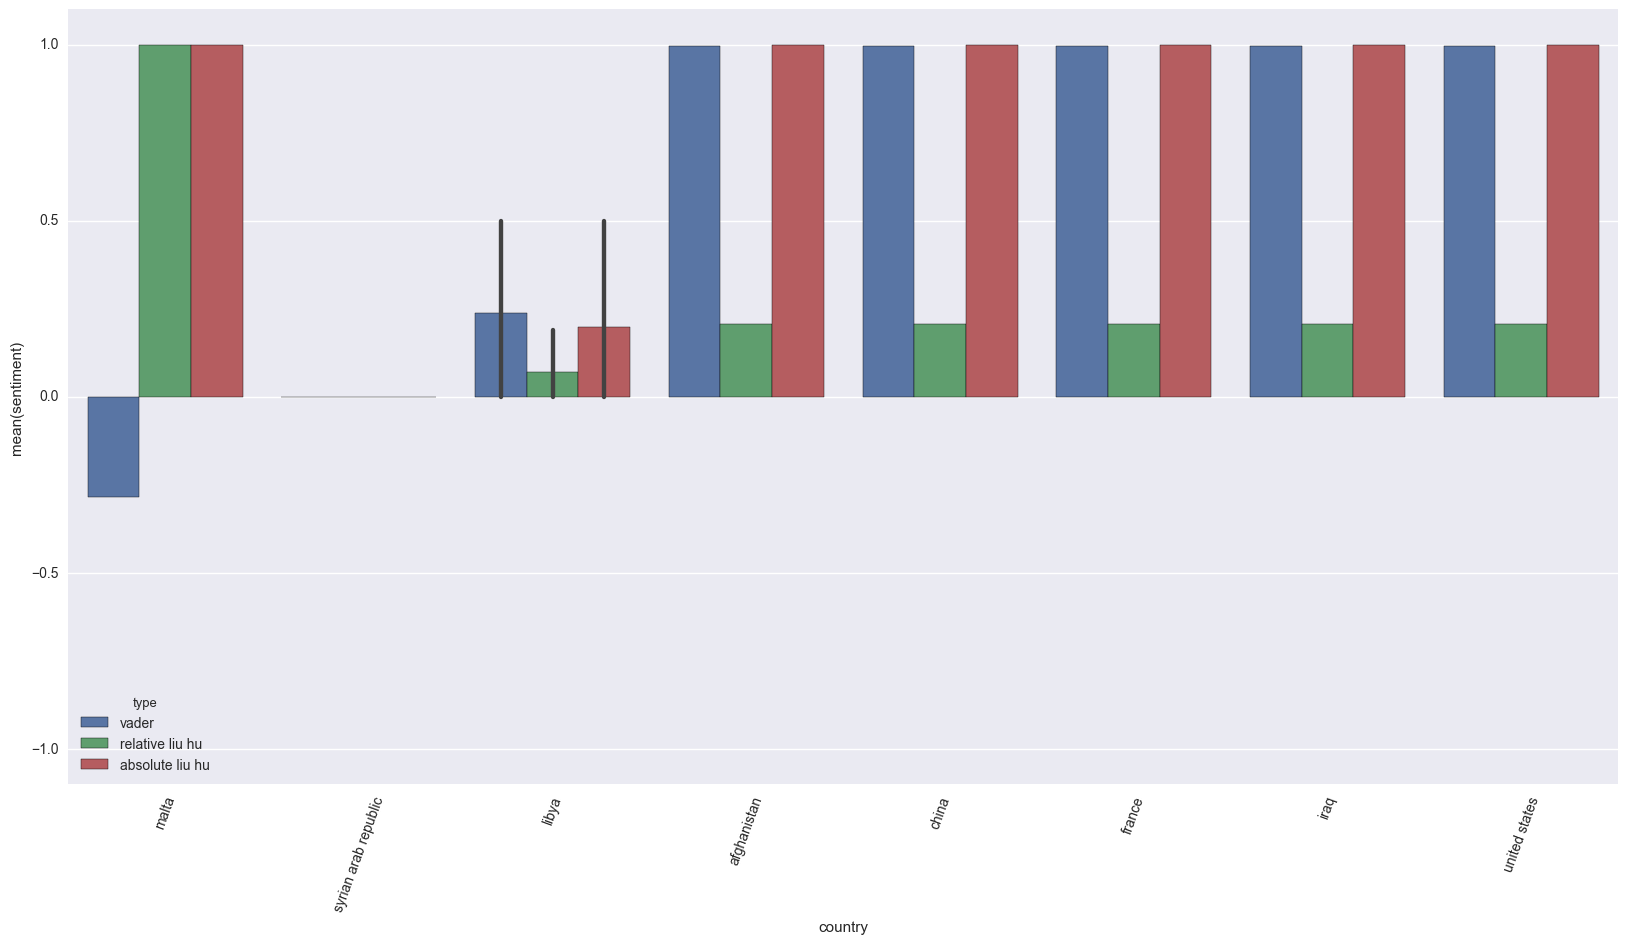

In [27]:
sentiment_dict_map = {'vader': vader_sentiment_dict,
                      'absolute liu hu': liu_hu_absolute_dict, 
                      'relative liu hu': liu_hu_relative_dict}
makeAdvancedPlotForAllSentimentDict(sentiment_dict_map)

We chose not to plot the ponderated liu hu lexicon as the result as it was difficult to compare it with the other plots. So we obser

In [ ]:
makeAdvancedPlotForAllSentimentDict({'vader': vader_sentiment_dict})

In [ ]:
sns.set(style="whitegrid", color_codes=True)
def makePlotForSentimentDict(sentiment_dict, min_nb_sentiment_value=4, y_min= -1.1, y_max = 1.1):
    plot_df = makeAdvancedDfFromDict('analysis', sentiment_dict, min_nb_sentiment_value)
    order = pd.Series(aggregateSentimentInformation(sentiment_dict,min_nb_sentiment_value)).sort_values().index # Order of columns in plot
    
    plt.ylim(y_min, y_max)
#     plot = sns.stripplot(x="country", y="sentiment", data = plot_df, order = order);
    plot = sns.boxplot(x="country", y="sentiment", data = plot_df, order=order);
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    return plot

In [ ]:
makePlotForSentimentDict(vader_sentiment_dict)

In [ ]:
makePlotForSentimentDict(liu_hu_absolute_dict)

In [ ]:
makePlotForSentimentDict(liu_hu_relative_dict)

In [ ]:
makePlotForSentimentDict(liu_hu_ponderated_dict, 4, -0.01, 0.5)

# Bonus question

In [ ]:
## Import receiver data
receiver_filename = os.path.join('hillary-clinton-emails','EmailReceivers.csv')
receiverdf = pd.read_csv(receiver_filename)
receiverdf.PersonId.max()

In [ ]:
df_email_initial.head(2)

In [ ]:
email_senders_map = {}
def makeEmailSendersMap(row):
    senderId = row.SenderPersonId
    if not np.isnan(senderId):
        email_senders_map[row.Id] = int(senderId)

In [ ]:
df_email_initial.apply(makeEmailSendersMap, axis=1)
email_senders_map[1]

In [ ]:
## Method to create the graph
import networkx as nx
sendReceiveGraph = nx.Graph()

def createGraphWithReceivers(row):
    email_id = row.EmailId
    receiver_id = row.PersonId
    if email_id and receiver_id and email_senders_map.get(email_id):
        sendReceiveGraph.add_edge(email_senders_map[email_id], receiver_id, {'email_id':email_id})

In [ ]:
receiverdf.apply(createGraphWithReceivers, axis=1)
print('finished')

In [ ]:
from operator import itemgetter
sorted(sendReceiveGraph.degree_iter(),key=itemgetter(1),reverse=True)

In [ ]:
d = nx.degree(sendReceiveGraph)
plt.figure(figsize=(20,15))
nx.draw(sendReceiveGraph, nodelist=d.keys(), node_size=[v * 20 for v in d.values()])

# plt.draw()
# plt.show()

In [ ]:
sendReceiveGraph.nodes()

In [ ]:
import community
partition = community.best_partition(sendReceiveGraph)

In [ ]:
size = float(len(set(partition.values())))
pos = nx.spring_layout(sendReceiveGraph)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(sendReceiveGraph, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))

plt.figure(figsize=(20,15))
nx.draw_networkx_edges(sendReceiveGraph,pos, alpha=0.5)
plt.show()

In [ ]:
set(partition.values())

In [ ]:
aa = {1: {'aa':2, 'bb': 3, 'cc': 1}, 2: {'bb': 5}}
aa[1]
import heapq
heapq.nlargest(3, aa[1], key=aa[1].get)

In [ ]:
partitionMailMap = {}  ## map between: {partition id -> { token -> occurence}}

for i in range(0,len(set(partition.values()))):
    partitionMailMap[i] = {}

def addMailWordsToPartition(row):
    senderId = row.SenderPersonId
    if not np.isnan(senderId):
        partitionNum = partition[senderId]
        tokenlist = tokenlistmap[row.name] #### ! IN CASE OF tokenlistmap ! 
        for token in tokenlist:
            if partitionMailMap[partitionNum].get(token):
                partitionMailMap[partitionNum][token] += 1
            else:
                partitionMailMap[partitionNum][token] = 0

In [ ]:
def getMostUsedWordsOfDictionary(token_dict):
    '''
    Input: Dictionary : {token -> occurence}
    Output: List[token_1, token_2, ..., token_20] with occurence(token_i) > occurence(token_j) for i > j
    '''
    return heapq.nlargest(20, token_dict, key=token_dict.get)

In [ ]:
print('We will have', len(set(partition.values())), 'communities.')
for partition_id in partitionMailMap:
    print('Community', partition_id,':')
    most_used_words_list = getMostUsedWordsOfDictionary(partitionMailMap[partition_id])
    print(most_used_words_list)
#     for word in most_used_words_list:
#         print(word)

In [ ]:
df_email_initial.RawText[0]
# stem_tokens[1]

In [ ]:
import networkx as nx


In [ ]:

G=nx.Graph()
# G.add_node(0)
# G.add_node(1)
G.add_edge('nice', 'hello', emailId=2)
G.add_edges_from([(2,3,{'color':'green'}), (3,4)])

In [ ]:

pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G,'state')
nx.draw(G, pos)
nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)

# Other

In [ ]:
plot_row_lists = []
for country in vader_sentiment_dict:
    for val in vader_sentiment_dict[country]:
        plot_row_lists.append({'country': country, 'sentiment': val})
plot_row_lists[:3]

In [ ]:
vader_result = aggregateSentimentInformation(vader_sentiment_dict)
pd.Series(vader_result).sort_values().index

In [ ]:
vader_result = aggregateSentimentInformation(vader_sentiment_dict)
pd.DataFrame.from_dict(vader_result, orient='columns', index='a')
results_series = pd.Series(vader_sentiment_dict, name='sentiments_val')
results_series.index.name = 'country'
plot_df = pd.DataFrame(results_series.reset_index())
plot_df.sort_values('sentiments_val', inplace=True)
plot_df.head(2)
plot_df = pd.DataFrame(plot_row_lists)

In [ ]:
sns.set(style="whitegrid", color_codes=True)
tips = sns.load_dataset("tips")

In [ ]:
plot = sns.stripplot(x="country", y="sentiment", data=plot_df);
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot

In [ ]:
tips

In [ ]:
x = ['a', 'b', 'c']
b = ['a'] if 'aa' in x else ''
[a if a is 'a' else 'b' for a in x]

In [ ]:
print('hey')

In [ ]:
nltk.download('opinion_lexicon')
nltk.download('vader_lexicon')

In [ ]:
from nltk.classify import NaiveBayesClassifier, MaxentClassifier
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import LinearSVC
import nltk.sentiment.util

naive_bayes = NaiveBayesClassifier.train
svm = SklearnClassifier(LinearSVC()).train
maxent = MaxentClassifier.train

nltk.sentiment.util.demo_vader_instance(df_email.ExtractedBodyText[13])

In [ ]:
nltk.sentiment.util.demo_liu_hu_lexicon(df_email.ExtractedBodyText[13], plot=True)

In [ ]:
def my_demo_liu_hu_lexicon(sentence, plot=False):
    """
    Basic example of sentiment classification using Liu and Hu opinion lexicon.
    This function simply counts the number of positive, negative and neutral words
    in the sentence and classifies it depending on which polarity is more represented.
    Words that do not appear in the lexicon are considered as neutral.
    :param sentence: a sentence whose polarity has to be classified.
    :param plot: if True, plot a visual representation of the sentence polarity.
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    neut_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    x = list(range(len(tokenized_sent))) # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            print('positive: ',word)
            pos_words += 1
            y.append(1) # positive
        elif word in opinion_lexicon.negative():
            print('negative: ', word)
            neg_words += 1
            y.append(-1) # negative
        else:
            neut_words += 1
            y.append(0) # neutral
    print('Positive words: ', pos_words)
    print('Negative words: ', neg_words)
    print('Neutral words: ', neut_words)

    if pos_words > neg_words:
        print('Positive')
    elif pos_words < neg_words:
        print('Negative')
    elif pos_words == neg_words:
        print('Neutral')


In [ ]:
my_demo_liu_hu_lexicon(df_email.ExtractedBodyText[13])

In [ ]:
# df_email.ExtractedBodyText[13]

In [ ]:
pydic = {'Switzerland': {'CH':[0.2, 0.5, 1.5], 'Suisse': [1,2,3]}, 'Germany':{'GE': [2,2.1, 6, 8], 'Allemagne': [2]} }

In [ ]:
pydic.get('Switzerland').get('CH')

In [ ]:
pydic

In [ ]:
for a in pydic:
    print(pydic.get(a))

In [ ]:
if not pydic.get('Switzerlands'):
    pydic['Switzerlands'] = [2]
pydic

In [ ]:
testaaa = {'Switzerland': [0.2, 0.5, 1.5], 'Suisse': [1,2,3], 'Germany': [2,2.1, 6, 8], 'Allemagne': [2]}

In [ ]:
testaaa['aaa'] = [2]
testaaa

In [ ]:
update_sentiment_dict('key', testaaa, 25)
testaaa

In [ ]:
np.mean(testaaa['Germany'])

In [ ]:
(2 + 2.1 + 6 + 8)/4

# Old function:

In [ ]:
def analyzeSentimentInDfOLD(row):
    emailContent = str(row.ExtractedBodyText).lower()
#     if('syria' in emailContent):
#             if (row.ExtractedSubject):
#                 print("Subject: ",row.ExtractedSubject, "\n")
#             print(emailContent)
#             print('-----------------------------------------------------------------------------')
    foundCountryGlobal = False
    for country in countryNamesAbbrev:
        foundCountry = False
        for abrev in country:
            if not foundCountry and abrev in emailContent:
                if(not foundCountryGlobal):
                    print('------------------------------- EMAIL N0: ', row.Id, ' -------------------------------')
                    print('COUNTRIES:')
                foundCountry = True
                foundCountryGlobal = True
                print(country[0], ': ',abrev)
    if foundCountryGlobal:
        pass
        print('--------- EMAIL CONTENT ---------')

        print(emailContent)
#         if any(abrev in emailContent for abrev in country):
#             print(abrev)
#         print(emailContent)
#         if('9.11' in emailContent):
#             print(emailContent)
#             print('-----------------------------------------------------------------------------')
#             print('-----------------------------------------------------------------------------')

#         if any(abrev in emailContent for abrev in country):
#             print('hey')